<h1>Содержание<span class="tocSkip"></span></h1> 
<br>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

# Восстановление золота из руды

Компания "Цифра" разрабатывает решения для эффективной работы промышленных предприятий. В нашем случае это предприятие, занимающееся восстановлением золота из золотосодержащей руды. 
____

**Описание данных:** Предоставлены различные параметры процессов, происходящих при золотоочистке.  

***Технологический процесс:***
* **Rougher feed** — исходное сырье
* **Rougher additions (или reagent additions)** — флотационные реагенты: Xanthate, Sulphate, Depressant
* **Xanthate** — ксантогенат (промотер, или активатор флотации);
* **Sulphate** — сульфат (на данном производстве сульфид натрия);
* **Depressant** — депрессант (силикат натрия).
* **Rougher process** (англ. «грубый процесс») — флотация
* **Rougher tails** — отвальные хвосты
* **Float banks** — флотационная установка
* **Cleaner process** — очистка
* **Rougher Au** — черновой концентрат золота
* **Final Au** — финальный концентрат золота

***Параметры этапов:***
* **air amount** — объём воздуха
* **fluid levels** — уровень жидкости
* **feed size** — размер гранул сырья
* **feed rate** — скорость подачи
____

**Наименование признаков:**

Наименование признаков должно быть такое:

**[этап].[тип_параметра].[название_параметра]**

Возможные значения для блока [этап]:
* **rougher** — флотация
* **primary_cleaner** — первичная очистка
* **secondary_cleaner** — вторичная очистка
* **final** — финальные характеристики

Возможные значения для блока [тип_параметра]:
* **input** — параметры сырья
* **output** — параметры продукта
* **state** — параметры, характеризующие текущее состояние этапа
* **calculation** — расчётные характеристики

____

**Задача:** Подготовить данные, провести исследовательский анализ данных, построить и обучить модель
____

**Цель:** Оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками. 

## Подготовка данных

In [1]:
#Подгружаем необходимые библиотеки для работы с данными и машинного обучения
import warnings
import timeit
import pandas as pd 
import catboost
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  Lasso,
                                  ElasticNet)
from catboost import CatBoostRegressor
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             f1_score, 
                             roc_curve, 
                             roc_auc_score, 
                             confusion_matrix)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats as st

#Подгружаем дополнительные полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Уберем warnings, чтобы не мешали
warnings.filterwarnings("ignore")

In [3]:
#Сделаем так, чтобы можно было выводить таблицу полностью
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
#Загружаем файлы с данными
try:
    data_train = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Спринт 9. Сборный проект/gold_recovery_train_new.csv')
    data_test = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Спринт 9. Сборный проект/gold_recovery_test_new.csv')
    data_full = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Спринт 9. Сборный проект/gold_recovery_full_new.csv')
except:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [5]:
#Проверяем каждый датафрейм
data_train.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [6]:
data_test.head(10)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [7]:
data_full.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [8]:
#Выведем информацию о каждом датафрейме
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [10]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Сразу же бросается в глаза, что столбец date необходимо перевести в формат даты для всех датафреймов. 

In [11]:
#Переводим признак date в формат даты
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%d %H:%M:%S')

In [12]:
#Выведем описание для обучающей и тестовой выборок
data_train.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,14148.0,5.142,1.370,0.000000e+00,4.212,4.995,5.860,16.002
final.output.concentrate_pb,14148.0,10.133,1.655,0.000000e+00,9.297,10.297,11.171,17.032
final.output.concentrate_sol,13938.0,9.203,2.791,0.000000e+00,7.485,8.845,10.488,18.125
final.output.concentrate_au,14149.0,44.004,4.905,0.000000e+00,43.276,44.872,46.166,52.757
final.output.recovery,14149.0,66.519,10.295,0.000000e+00,62.546,67.433,72.346,100.000
final.output.tail_ag,14149.0,9.607,2.319,0.000000e+00,7.997,9.480,11.004,19.552
final.output.tail_pb,14049.0,2.597,0.972,0.000000e+00,1.906,2.592,3.242,5.640
final.output.tail_sol,14144.0,10.512,3.004,0.000000e+00,8.811,10.515,11.933,22.318
final.output.tail_au,14149.0,2.918,0.904,0.000000e+00,2.369,2.851,3.435,8.197
primary_cleaner.input.sulfate,14129.0,133.321,39.432,3.000000e-03,107.007,133.018,159.825,250.128


In [13]:
data_test.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5286.0,174.840,43.027,2.566,147.121,177.828,208.125,265.983
primary_cleaner.input.depressant,5285.0,8.684,3.072,0.004,6.490,8.052,10.028,40.000
primary_cleaner.input.feed_size,5290.0,7.266,0.610,5.650,6.890,7.250,7.600,15.500
primary_cleaner.input.xanthate,5286.0,1.384,0.643,0.005,0.908,1.198,1.798,4.102
primary_cleaner.state.floatbank8_a_air,5290.0,1539.494,116.798,0.000,1498.936,1585.129,1602.077,2103.104
primary_cleaner.state.floatbank8_a_level,5290.0,-497.666,19.952,-795.316,-500.357,-499.969,-499.569,-57.195
primary_cleaner.state.floatbank8_b_air,5290.0,1545.174,122.225,0.000,1498.971,1595.622,1602.324,1813.084
primary_cleaner.state.floatbank8_b_level,5290.0,-500.273,32.968,-799.997,-500.703,-500.029,-499.293,-142.527
primary_cleaner.state.floatbank8_c_air,5290.0,1527.272,122.538,0.000,1473.230,1549.595,1601.144,1715.054
primary_cleaner.state.floatbank8_c_level,5290.0,-498.331,21.965,-799.961,-501.018,-500.018,-498.994,-150.937


Выделим параметры, которые нам необходимы для нахождения эффективности процессов:
1) **Флотация**:
* **rougher.output.concentrate_au (Сf)** - доля золота после флотации / перед первой очисткой;
* **rougher.input.feed_au (Ff)** - доля золота в начальном сырье;
* **rougher.output.tail_au (Tf)**  - доля золота в хвостах после флотации. 

2) **Первая очистка**:
* **primary_cleaner.output.concentrate_au (С1)** - доля золота после первой очистки;
* **rougher.output.concentrate_au (F1)**  - доля золота после флотации / перед первой очисткой;
* **primary_cleaner.output.tail_au (T1)**  - доля золота в хвостах после первой очистке.

3) **Вторая очистка**:
* **final.output.concentrate_au (С2)** - доля золота в финальном продукте;
* **primary_cleaner.output.concentrate_au (F2)**  - доля золота в концентрате перед второй очисткой / после первой очистки;
* **secondary_cleaner.output.tail_au (T2)**  - доля золота в хвостах после второй очистки.

Попробуем рассчитать эффективность каждого процесса по формуле, предварительно написав функцию. Сравнить мы сможем их только с двумя параметрами: 
* **rougher.output.recovery** - эффективность обогащения после флотации
* **final.output.recovery** - эффективность обогащения после заключительной очистки

Для этих процессов и будем считать эффективность.

In [14]:
#Сначала проверим, есть ли пропуски в обучающей выборке для необходимых нам параметров при расчете
calc_param_effect = ['rougher.output.concentrate_au', 
                     'rougher.input.feed_au', 
                     'rougher.output.tail_au', 
                     'final.output.concentrate_au',
                     'primary_cleaner.output.concentrate_au', 
                     'secondary_cleaner.output.tail_au',
                     'rougher.output.recovery',
                     'final.output.recovery']

data_train[calc_param_effect].isna().sum()

rougher.output.concentrate_au            0
rougher.input.feed_au                    0
rougher.output.tail_au                   0
final.output.concentrate_au              0
primary_cleaner.output.concentrate_au    0
secondary_cleaner.output.tail_au         0
rougher.output.recovery                  0
final.output.recovery                    0
dtype: int64

In [15]:
#Напишем функцию для расчета МАЕ между расчетынми и фактическими занчениями
def recovery(data, C, F, T, fact, proc):
    effect = data[C]*(data[F]-data[T]) / (data[F]*(data[C]-data[T])) * 100
    mae = mean_absolute_error(data[fact], effect)
    print(f'Для процесса {proc}: {mae}')

#Применим функцию для флотации     
recovery(data_train, 
         'rougher.output.concentrate_au', 
         'rougher.input.feed_au', 
         'rougher.output.tail_au', 
         'rougher.output.recovery',
         'Флотация')

#При применении фукнции для вторичной очистки вылезают бесконечные и неопределенные значения в связи с нулевыми значениями переменных, 
#поэтмоу огранчиимся флотацией

Для процесса Флотация: 9.73512347450521e-15


Согласно полученному МАЕ, разница между расчетными и фактическими данными по эффективности обогащения очень мала. Фактические данные расчитаны корректно 

In [16]:
#Определим признаки, которых нету в тестовой выборке
no_test_features = list(data_train.drop(data_test.columns, axis=1).columns)
no_test_features

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Видно, что эти признаки являются результатом процессов флотации и очисток, а также некоторых вычислений. Получается, в тестовой выборке находятся признаки, необходимые для того, чтобы получить предсказания (features). А остальные признаки, которые есть в обучающей выборке, могут быть целевыми (target). Их два ключевых - это эффективность *recovery* для процессов флотации и очистки. 

Пропущенных значений не так много, поэтому их можно удалить. К тому же мы не настолько хорошо погружены в процесс золотоочистки, чтобы попытаться их с какой-то долей уверенности чем-то заменить. \
Удалить лучше их только только в тех признаках, которые нам понадобятся для обучения и предсказания модели.

In [17]:
no_test_features.insert(0, 'date')

In [18]:
#Удалим пропущенные значения только в необходимых нам в дальнейшем признаках
list_features = list(data_test.columns)
list_features.append('final.output.recovery')
list_features.append('rougher.output.recovery')

data_train_1 = data_train[list_features].dropna()
data_test_1 = data_test.dropna()

data_train_1 = pd.merge(data_train_1, data_full[no_test_features]).reset_index(drop=True)

print(data_train_1.shape)
print(data_test_1.shape)

(12666, 87)
(5229, 53)


Данные надо разделить между собой таким образом, чтобы параметры флотации были в отдельном датафрейме в тестовой и обучающей выборках, так как по тех. заданию необходимо отдельно спрогнозировать эффективность процесса флотации. Это самый первый процесс, поэтому остальные параметры не могут повлиять на него повлиять. \
Для прогноза финального концентрата необходим полный набор данных, так как он в себя вбирает результат всех процессов.

In [19]:
#Создаем списки для названия столбцов отдельно для rougher
def col_roug(data):
    col_rougher = ['date']
    for i in data.columns:
        if 'rougher' in i:
            col_rougher.append(i)
    return col_rougher
            
print(len(col_roug(data_full)))

36


Отлично, по количеству столбцов все сходится.

In [20]:
#Теперь создаем разделенные датафреймы для каждой выборки
data_train_rougher = data_train_1[col_roug(data_train)]
data_full_rougher = data_full[col_roug(data_full)]
data_test_rougher = data_test_1[col_roug(data_test)]

**Выводы:**

1) Данные переведены в необходимые форматы; \
2) Удалены дубликаты и пропущенные значения; \
3) Данные по эффективности процессов представлены кооректно согласно сравнению с расчетом по формуле; \
4) В тестовой выборке отсутствуют значения результата процессов и некоторых вычислений, т.е. представлены признаки features, по которым необходимо делать прогноз; \
5) Данные разделены на два вида, соответствующие процессам флотации и очистки по отдельности. 

## Анализ данных

Теперь проследим изменение концентрации элементов на каждом этапе. 

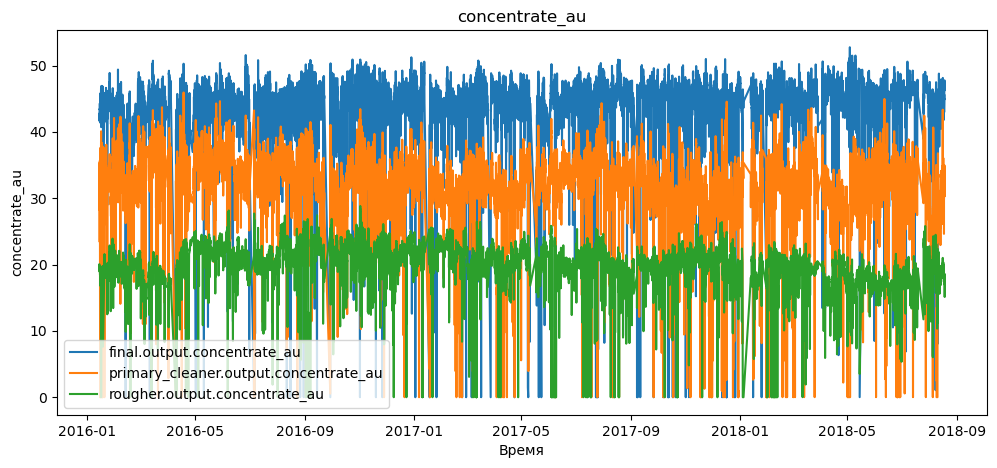

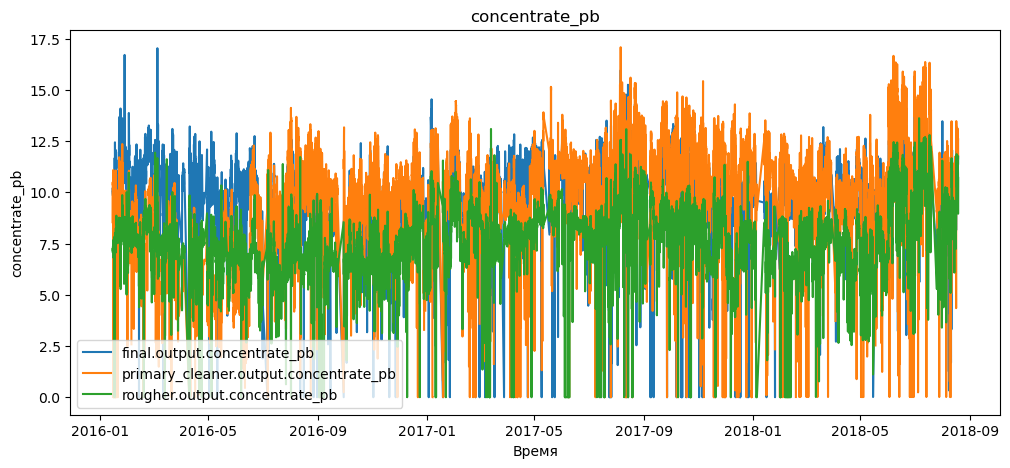

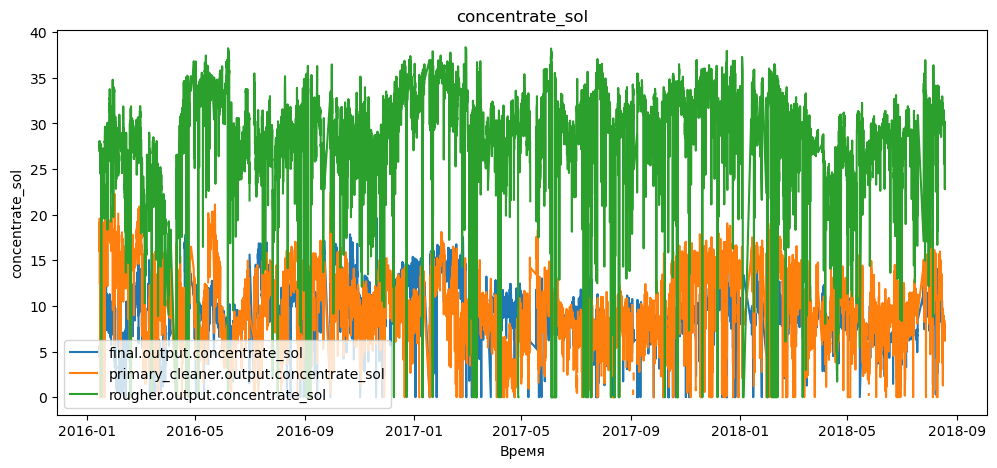

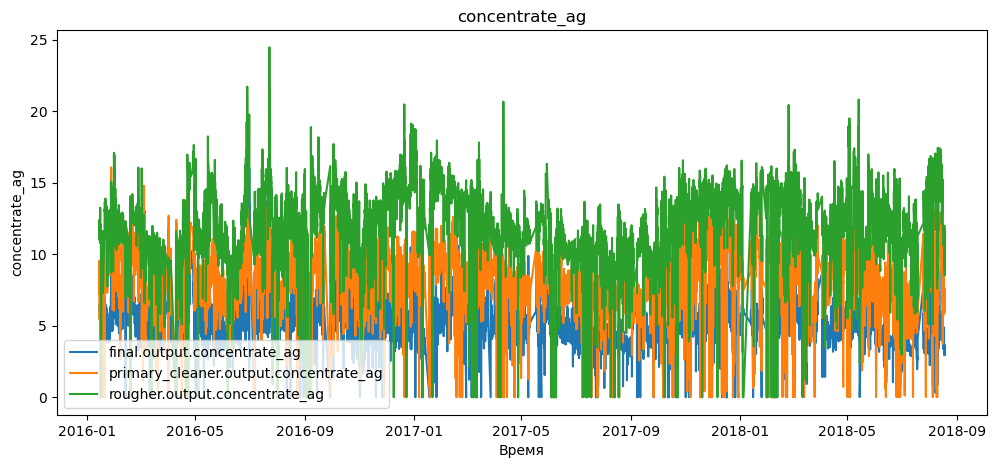

In [21]:
#Сделаем функцию для построения графиков
def concentration(conc_elem, data):
    plt.figure(figsize=(12,5))
    for i in data.columns:
        if conc_elem in i:
            plt.plot(data['date'], data[i], label=i)
    plt.title(conc_elem)
    plt.xlabel('Время')
    plt.ylabel(conc_elem)
    plt.legend(loc=3)
    
#Построим графики
for i in ['concentrate_au', 'concentrate_pb', 'concentrate_sol', 'concentrate_ag']:
    concentration(i, data_full)

Можно сделать некоторые выводы по данным графикам:
* Концентрация золота (Аu) - с каждым новым этапом очистки концентрация золота растет, что логично;
* Концентрация свинца (Pb) - в целом можно сделать вывод, что концентарция свинца увеличивается после первой очистки и остается примерно такой же после второй очистки
* Концентрация соли(?) (Sol) - концентарция соли(?) значительно снижается после первой очистки и остается примерно такой же после второй очистки
* Концентрация серебра (Ag) - концентарция серебра поэтапно снижается от этапа к этапу

Теперь рассмотрим распределение величины зерен в обучающих и тестовых выборках.

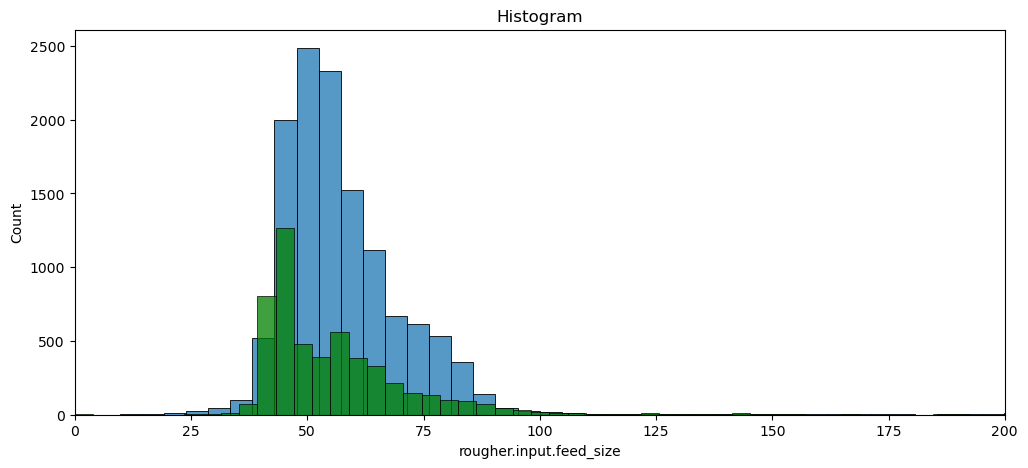

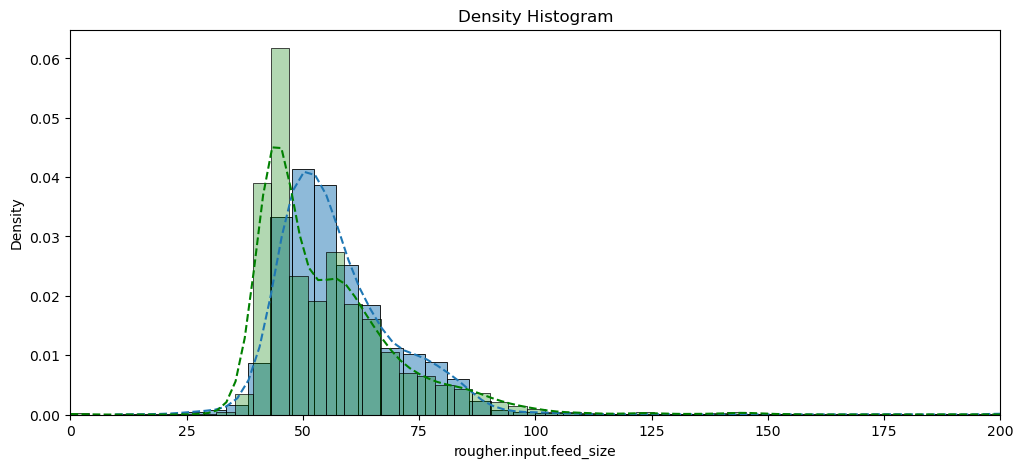

In [22]:
plt.figure(figsize=(12,5))
sns.histplot(data=data_train_1, x='rougher.input.feed_size', bins=100, common_norm=False);
sns.histplot(data=data_test_1, x='rougher.input.feed_size', bins=100, common_norm=False, color='green');
plt.xlim([0, 200])
plt.title("Histogram");

plt.figure(figsize=(12,5))

sns.histplot(data=data_train_1, 
             x='rougher.input.feed_size', 
             alpha=0.5,
             bins=100, 
             stat='density', 
             common_norm=False, 
             kde=True, 
             line_kws = {'color':'red','linestyle': 'dashed'});

sns.histplot(data=data_test_1, 
             x='rougher.input.feed_size',
             alpha=0.3,
             bins=100, 
             stat='density', 
             common_norm=False,
             kde=True, 
             color='green',
             line_kws = {'color':'green','linestyle': 'dashed'});
plt.xlim([0, 200]);
plt.title("Density Histogram");

Как показывает гистограмма плотности распределения параметра, распределение величины зерен в обучающей и тестовых выборках примерно схожи.  

Далее рассмотрим, как меняется суммарная концентрация элементов в продукте во всех процессах.

,feed,rougher,final
count,19245.000000,19416.000000,19227.000000
mean,57.407926,68.188914,68.727562
std,7.165219,12.478522,7.423741
min,0.040000,0.000000,0.000000
25%,53.660745,66.026048,67.985659
50%,57.647093,70.186130,69.632597
75%,62.012223,74.362878,71.390461
max,76.978947,88.140119,80.210644


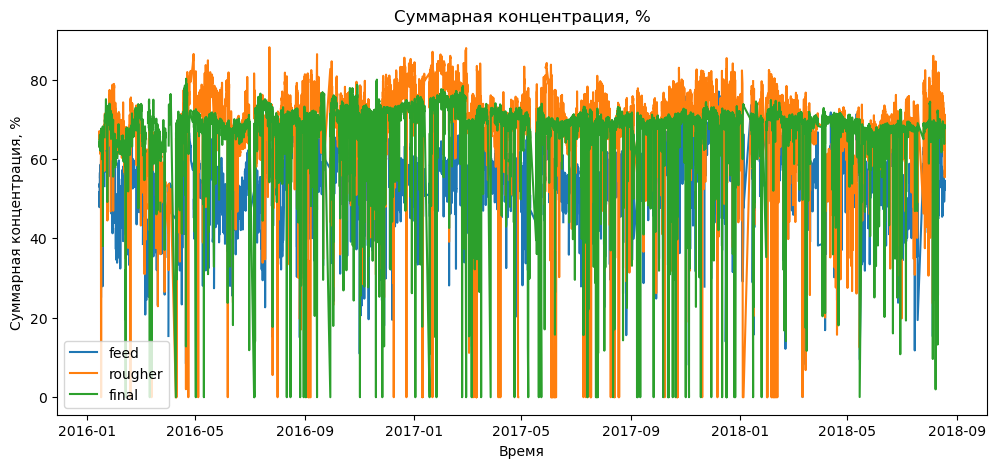

In [23]:
sum_conc = pd.DataFrame()
sum_conc['date'] = data_full['date']

sum_conc['feed'] = (data_full['rougher.input.feed_au'] 
                     + data_full['rougher.input.feed_ag'] 
                     + data_full['rougher.input.feed_pb']
                     + data_full['rougher.input.feed_sol']
                   )

sum_conc['rougher'] = (data_full['rougher.output.concentrate_au'] 
                     + data_full['rougher.output.concentrate_ag'] 
                     + data_full['rougher.output.concentrate_pb']
                     + data_full['rougher.output.concentrate_sol']
                   )

sum_conc['final'] = (data_full['final.output.concentrate_au'] 
                     + data_full['final.output.concentrate_ag'] 
                     + data_full['final.output.concentrate_pb']
                     + data_full['final.output.concentrate_sol']
                    )

plt.figure(figsize=(12,5));
plt.plot(sum_conc['date'], sum_conc['feed'], label='feed');
plt.plot(sum_conc['date'], sum_conc['rougher'], label='rougher');
plt.plot(sum_conc['date'], sum_conc['final'], label='final');
plt.title('Суммарная концентрация, %');
plt.xlabel('Время');
plt.ylabel('Суммарная концентрация, %');
plt.legend(loc=3);

sum_conc.describe()

По графикам и описанию суммарной концентрации для каждого процесса видно, что в сырье концентрация металлов ниже, чем в черновом и финальном концентратах. Это логично, ведь как раз процесс флотации необходим, чтобы убрать лишние элементы и вещества и оставить полезные. \
Также можно отметить, что между черновым и финальным концентратом в плане суммарной концентрации нет большой разницы, но по стандартному отклонению можно заметить, что суммарная концентарция более постояна после очистки. Это говорит о том, что во время очистки уже добиваются достижения увеличения концентрации золота с дополнительным удалением бесполезных элементов и некоторых других элементов (Sol и Ag). 

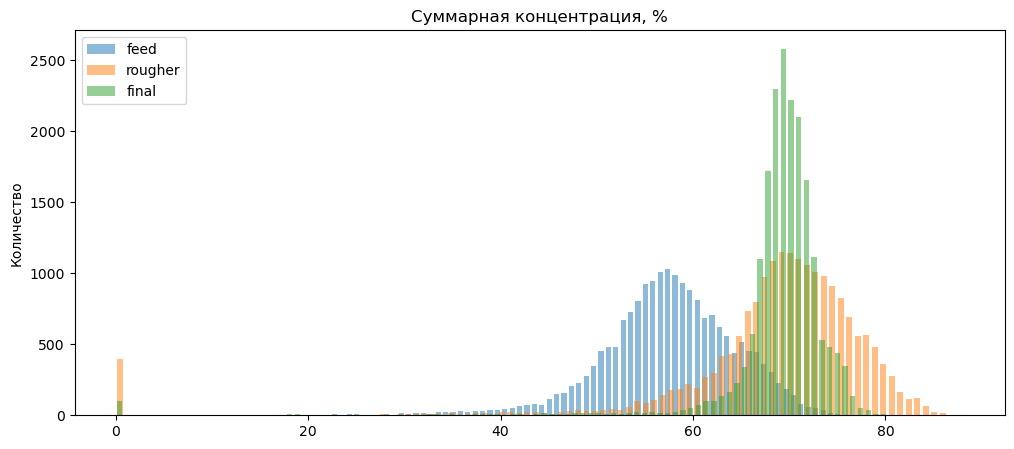

In [24]:
#Потроим вместо графика гистгораммы
plt.figure(figsize=(12,5));
plt.hist(sum_conc['feed'], bins=100, label='feed', alpha=0.5, rwidth=0.7)
plt.hist(sum_conc['rougher'], bins=100, label='rougher', alpha=0.5, rwidth=0.7)
plt.hist(sum_conc['final'], bins=100, label='final', alpha=0.5, rwidth=0.7)
plt.title('Суммарная концентрация, %');
plt.ylabel('Количество');
plt.legend(loc=2);

In [25]:
#Есть нулевые значения в суммарной концентрации, их необходимо удалить из тестовой и обучающей выборок

def sum_conc(data):
    
    data['sum_feed'] = (data['rougher.input.feed_au'] 
                     + data['rougher.input.feed_ag'] 
                     + data['rougher.input.feed_pb']
                     + data['rougher.input.feed_sol']
                   )

    data['sum_rougher'] = (data['rougher.output.concentrate_au'] 
                     + data['rougher.output.concentrate_ag'] 
                     + data['rougher.output.concentrate_pb']
                     + data['rougher.output.concentrate_sol']
                   )
    
    data['sum_final'] = (data['final.output.concentrate_au'] 
                     + data['final.output.concentrate_ag'] 
                     + data['final.output.concentrate_pb']
                     + data['final.output.concentrate_sol']
                    )
    
    data = data.loc[(data['sum_feed'] > 0) & (data['sum_rougher'] > 0) & (data['sum_final'] > 0)]
    data = data.drop(['sum_feed', 'sum_rougher', 'sum_final'], axis=1)
    
    return data
  
data_train_2 = sum_conc(data_train_1)

#Сразу же подготовим данные к будущему использованию в модели
data_train_2 = data_train_2[list_features]
print(data_train_2.shape)
data_train_rougher = data_train_2[col_roug(data_train_2)]
print(data_train_rougher.shape)

(12215, 55)
(12215, 24)


In [26]:
#Для тестовой выборки сначала необходимо сделать объединение с некоторыми output парамтерами из data_full
list_output_params = ['date', 
                      'rougher.output.concentrate_au', 
                      'rougher.output.concentrate_pb', 
                      'rougher.output.concentrate_ag', 
                      'rougher.output.concentrate_sol', 
                      'final.output.concentrate_au', 
                      'final.output.concentrate_ag', 
                      'final.output.concentrate_pb',
                      'final.output.concentrate_sol']

data_test_full = pd.merge(data_test_1, data_full[list_output_params]).reset_index(drop=True)

data_test_2 = sum_conc(data_test_full)
list_test = list(data_test_1.columns)
data_test_2 = data_test_2[list_test]

print(data_test_2.shape)
data_test_rougher = data_test_2[col_roug(data_test_2)]
print(data_test_rougher.shape)

(5105, 53)
(5105, 23)


**Выводы:**

1) Можно сделать некоторые выводы по графикам изменения концентрации элементов для каждого процесса:
* Концентрация золота (Аu) - с каждым новым этапом очистки концентрация золота растет, что логично;
* Концентрация свинца (Pb) - в целом можно сделать вывод, что концентарция свинца увеличивается после первой очистки и остается примерно такой же после второй очистки
* Концентрация соли(?) (Sol) - концентарция соли(?) значительно снижается после первой очистки и остается примерно такой же после второй очистки
* Концентрация серебра (Ag) - концентарция серебра поэтапно снижается от этапа к этапу;

2) Как показывает гистограмма плотности распределения параметра, распределение величины зерен в обучающей и тестовых выборках примерно схожи;

3) По графикам и описанию суммарной концентрации для каждого процесса видно, что в сырье концентрация металлов ниже, чем в черновом и финальном концентратах. Это логично, ведь как раз процесс флотации необходим, чтобы убрать лишние элементы и вещества и оставить полезные. Также можно отметить, что между черновым и финальным концентратом в плане суммарной концентрации нет большой разницы, но по стандартному отклонению можно заметить, что суммарная концентарция более постояна после очистки. Это говорит о том, что во время очистки уже добиваются достижения увеличения концентрации золота с дополнительным удалением бесполезных элементов и некоторых других элементов (Sol и Ag). 

## Модель

Теперь необходимо создать модель, которая будет достаточно точно прогнозировать эффективность восстановление золота после флотации и очистки. Метрикой качаства будет служить sMAPE.

Проверим разные виды моделей на обучающей выборке. Лучшую из них выберем с помощью кросс-валидации. Как уже было отмечено выше, для обучения и предсказания берем признаки из тестовой выборки, которые не зависят от результата.

In [27]:
#Уберем из всех данных столбец 'date', который не нужен при создании модели
data_train_rougher = data_train_rougher.drop(['date'], axis=1)
data_train_final = data_train_2.drop(['date'], axis=1)
data_test_rougher = data_test_rougher.drop(['date'], axis=1)
data_test_final = data_test_2.drop(['date'], axis=1)

In [28]:
#Разделим обучающую выборку на признаки и целевой признаки
features_rougher = data_train_rougher[data_test_rougher.columns]
target_rougher = data_train_rougher['rougher.output.recovery']
features_final = data_train_final[data_test_final.columns]
target_final = data_train_final['final.output.recovery']

Далее будут несколько функциий (для кросс-валидации и поиска лучшей модели), которые работают вместе и позвляют сделать общую сводную таблицу для всех методов. 

Сначала попробуем пойти по пути, который применялся для подбора моделей классификации. Но есть вероятность, что со Случайным лесом это будет очень долго.

Идея такая: 
* берем сначала средний диапазон, например [10,100,10];
* если лучшее решение будет с гиперпараметром 100 (макс. зн-е), то соответственно произойдет увеличение диапазона до [100,1000,100]; 
* если лучшее решение будет с гиперпараметром 10 (мин. зн-е), то соответственно произойдет уменьшение диапазона до [1,10,1];

Цикл каждого из данных направлений заканчивается, пока лучший гиперпараметр не будет находиться в промежутке между мин. и макс. значениями (это очень быстро).
    
* далее допустим, что лучшее решение получилось с гиперпараметром 900 при диапазоне [100,1000,100]. Тогда цикл сокращает диапазон до [800,1000,10]. Далее гипрепараметр получился, допустим, 860. Тогда диапазон сокращается до [850,870,1]. А уже из этого диапазона выбирается лучшее значение;
* Итог: получается максимальная точность при нахождении лучшего решения для каждого способа (проверено по сравнению с ручным поиском нужного диапазона  и на графиках) при полной автоматизации подбора диапазона, при этом поиск не занимает большого количества времени из-за постепенного отсечения значений диапазона.

Также было замечено, что ввод максимальной глубины деревьев в методе Рандомный лес не всегда улучшает искомую метрику. В любом случае в функции предусмотрен переход на поиск лучшего значения для max_depth.

In [29]:
#Напишем функцию для кросс-валидации и нахождения средней результирующей метрики 
def cross_valid(features, target, model):
    scores = []
    smape = 0
    features = features.reset_index(drop=True)
    target = target.reset_index(drop=True)
    
    #Зададим, насколько мы хотим разделить нашу выборку при валидации 
    sample_size = int(len(target)/5)
    
    #Теперь разделим выборку на обучающую и валидационную 
    for i in range(0, len(target)-sample_size, sample_size):
        valid_indexes = list(range(i, i+sample_size))
        train_indexes = list(range(len(target)))
        del train_indexes[i:(i+sample_size)]
        
        features_train = features.loc[train_indexes]
        features_valid = features.loc[valid_indexes]
        target_train = target.loc[train_indexes]
        target_valid = target.loc[valid_indexes]
        
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        predictions = pd.Series(predictions, index=target_valid.index)
        smape = (abs(target_valid - predictions) / ((target_valid + predictions) / 2)).sum() / target_valid.count() * 100 
        scores.append(smape)
    
    final_score = sum(scores)/len(scores) 
        
    return final_score

In [30]:
#Создадим функцию, которая будет находить лучший вариант в зависимости от выбора модели
#Максимальная глубина дерева для линейной регресси здесь подбирается с шагом 1 от 1 до 10

def model_choice(kind_model,
                 k, 
                 n, 
                 d):
#Начинаем отсчет времени
    start_time = timeit.default_timer()
#Ищем лучший вариант
    best_model = None
    best_smape = 1000
    best_hyperparam = 0
    best_depth = None
    
    for i in range(k,n,d):
        if kind_model == DecisionTreeRegressor:
            model=kind_model(random_state=12345, max_depth=i)          
        elif kind_model == RandomForestRegressor:
            model=kind_model(random_state=12345, n_estimators=i)
        elif kind_model == LinearRegression:         
            model=kind_model()

#Проводим кросс-валидацию             
        smape_rougher = cross_valid(features_rougher, target_rougher, model)
        smape_final = cross_valid(features_final, target_final, model)

#Находим финальный smape        
        final_smape = 0.25 * smape_rougher + 0.75 * smape_final 
        if final_smape < best_smape:
            best_model = model
            best_smape = final_smape
            best_hyperparam = i

#Теперь добавим еще глубину деревьев для уточнения модели Случайного леса
        if (kind_model == RandomForestRegressor) and (i == n-1) and (d==1):
            for j in range(1,10,1):
                model=kind_model(random_state=12345, n_estimators=best_hyperparam, max_depth=j)
                smape_rougher = cross_valid(features_rougher, target_rougher, model)
                smape_final = cross_valid(features_final, target_final, model)
                
                final_smape = 0.25 * smape_rougher + 0.75 * smape_final 
                if final_smape < best_smape:
                    best_model = model
                    best_smape = final_smape
                    best_depth = j
    
#Заканчиваем подсчет времени
    end_time = timeit.default_timer() - start_time
    return best_model, best_smape, end_time, best_hyperparam, best_depth

Перевел расчетную ячейку в текстовую, т.к. расчет идёт невероятно долго (возможно, не хвататет мощностей обычного ноутбука) и вылетает Jupyter. Для классификации все работало отлично, потому что было гораздо легче посчитать Случайный лес с количеством деревьев в несколько десятков и такой же глубиной.

Немного поменяем и упростим подход, чтобы была возможность найти лучшую модель быстрее. Начнем с k=1, n=10, d=1 и будем постепенно увеличивать границы интервала подбора параметра на 10. Метод немного хуже предыдущего способа, т.к. не учитывает картину изменения искомой метрики при изменении гиперпараметров на всей дистанции. Но это, вероятно, будет не так страшно, потому что лучшая максимальная глубина для Дерева решений зачастую меньше 10, а для Случайного леса после определенного значения гиперпараметра метрика обычно выходит на "плато", где изменения достаточно малы.     

In [31]:
#Немного поменяем функцию для определения максимальной глубины деревьев

def model_choice_1(kind_model,
                 k, 
                 n, 
                 d):
#Начинаем отсчет времени
    start_time = timeit.default_timer()
#Ищем лучший вариант
    best_model = None
    best_smape = 1000
    best_hyperparam = 0
    best_depth = None
    
    for i in range(k,n,d):
        if kind_model == DecisionTreeRegressor:
            model=kind_model(random_state=12345, max_depth=i)          
        elif kind_model == RandomForestRegressor:
            model=kind_model(random_state=12345, n_estimators=i)
        elif kind_model == LinearRegression:         
            model=kind_model()

#Проводим кросс-валидацию             
        smape_rougher = cross_valid(features_rougher, target_rougher, model)
        smape_final = cross_valid(features_final, target_final, model)

#Находим финальный smape        
        final_smape = 0.25 * smape_rougher + 0.75 * smape_final 
        if final_smape < best_smape:
            best_model = model
            best_smape = final_smape
            best_hyperparam = i

#Теперь добавим еще глубину деревьев для уточнения модели Случайного леса
        if (kind_model == RandomForestRegressor) and (i == n-1):
            for j in range(1,5,1):
                model=kind_model(random_state=12345, n_estimators=best_hyperparam, max_depth=j)
                smape_rougher = cross_valid(features_rougher, target_rougher, model)
                smape_final = cross_valid(features_final, target_final, model)
                
                final_smape = 0.25 * smape_rougher + 0.75 * smape_final 
                if final_smape < best_smape:
                    best_model = model
                    best_smape = final_smape
                    best_depth = j
    
#Заканчиваем подсчет времени
    end_time = timeit.default_timer() - start_time
    return best_model, best_smape, end_time, best_hyperparam, best_depth

Опять таки считается слишком долго из-за модели Случайного леса в совокупности с кросс-валидацией. \
На полное автоматическое определение лучшего гиперпараметра вместе с его диапозоном и вывода лучших моделей в сводную таблицу уходит достаточно много времени, это нерационально, поэтому рассмотрим каждую модель вручную.  

Добавим в функцию вывод графиков изменения лучшей метрики в зависимости от гиперпараметра. 

In [32]:
#Добавим вывод графиков

def model_choice_graf(kind_model,
                 k, 
                 n, 
                 d):
#Начинаем отсчет времени
    start_time = timeit.default_timer()
#Ищем лучший вариант
    best_model = None
    best_smape = 1000
    best_hyperparam = 0
    best_depth = None
    all_smape = []
    all_smape_depth = []
    x = []
    x_depth = []
    
    for i in range(k,n,d):
        if kind_model == DecisionTreeRegressor:
            model=kind_model(random_state=12345, max_depth=i)          
        elif kind_model == RandomForestRegressor:
            model=kind_model(random_state=12345, n_estimators=i, verbose=0)
        elif kind_model == LinearRegression:         
            model=kind_model()
        elif kind_model == CatBoostRegressor:         
            model=kind_model(depth=i, verbose=0)
        elif kind_model == Ridge:         
            model=kind_model()
        elif kind_model == Lasso:         
            model=kind_model()
        elif kind_model == ElasticNet:         
            model=kind_model()           

#Проводим кросс-валидацию             
        smape_rougher = cross_valid(features_rougher, target_rougher, model)
        smape_final = cross_valid(features_final, target_final, model)

#Находим финальный smape   
        final_smape = 0.25 * smape_rougher + 0.75 * smape_final 
        all_smape.append(final_smape)
        x.append(i)
        if final_smape < best_smape:
            best_model = model
            best_smape = final_smape
            best_hyperparam = i

#Теперь добавим еще глубину деревьев для уточнения модели Случайного леса
        if (kind_model == RandomForestRegressor) and (i == n-1):
            for j in range(1,10,1):
                model=kind_model(random_state=12345, n_estimators=best_hyperparam, max_depth=j, verbose=0)
                
                smape_rougher = cross_valid(features_rougher, target_rougher, model)
                smape_final = cross_valid(features_final, target_final, model)
                
                final_smape_depth = 0.25 * smape_rougher + 0.75 * smape_final 
                all_smape_depth.append(final_smape)
                x_depth.append(j)
                if final_smape_depth < best_smape:
                    best_model = model
                    best_smape = final_smape
                    best_depth = j
    
#Заканчиваем подсчет времени
    end_time = timeit.default_timer() - start_time
    
    if ((kind_model == DecisionTreeRegressor) or
        (kind_model == RandomForestRegressor) or
        (kind_model == CatBoostRegressor)):
        plt.figure(figsize=(12,5))
        plt.plot(x, all_smape)
        plt.title(kind_model)
        plt.xticks(np.arange(k,n,d))
        plt.xlabel('Гиперпараметр')
        plt.ylabel('sMAPE')
    
    if kind_model == RandomForestRegressor:
        plt.figure(figsize=(12,5))
        plt.plot(x_depth, all_smape_depth)
        plt.title(kind_model)
        plt.xticks(np.arange(k,n,d))
        plt.xlabel('Максимальная глубина')
        plt.ylabel('sMAPE')
    
    print('Лучшая модель:', best_model)
    print('Лучший sMAPE:', round(best_smape, 3))
    print('Время нахождения решения:', round(end_time, 3))
    print('Лучший гиперпараметр:', best_hyperparam)
    print('Лучшая глубина для RF:', best_depth)

    return best_model, best_smape, end_time, best_hyperparam, best_depth

Лучшая модель: DecisionTreeRegressor(max_depth=1, random_state=12345)
Лучший sMAPE: 7.992
Время нахождения решения: 11.308
Лучший гиперпараметр: 1
Лучшая глубина для RF: None


(DecisionTreeRegressor(max_depth=1, random_state=12345),
 7.991739741720271,
 11.3079313,
 1,
 None)

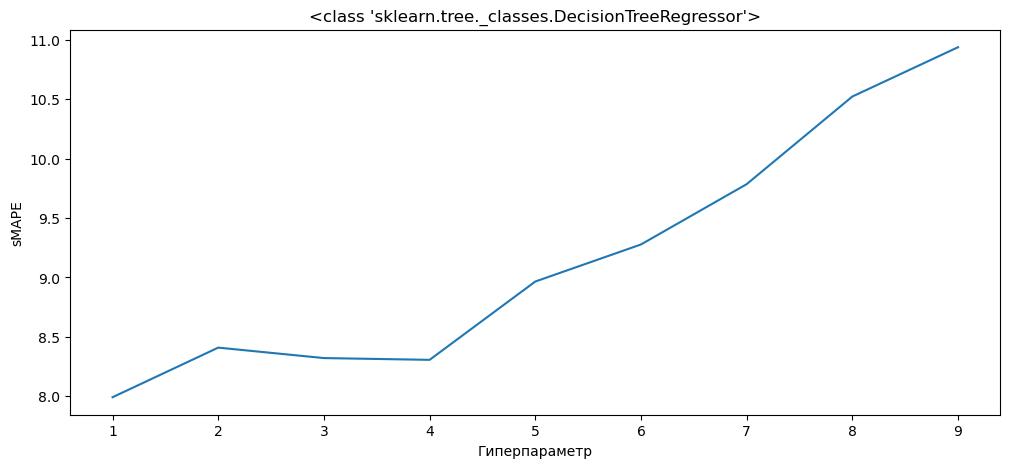

In [33]:
model_choice_graf(DecisionTreeRegressor, 1, 10, 1)

Видно, что для модели Дерева решений лучшей является DecisionTreeRegressor(max_depth=1, random_state=12345) с итоговым sMAPE, равным 7.992.

Лучшая модель: RandomForestRegressor(max_depth=9, n_estimators=14, random_state=12345)
Лучший sMAPE: 8.615
Время нахождения решения: 293.62
Лучший гиперпараметр: 14
Лучшая глубина для RF: 9


(RandomForestRegressor(max_depth=9, n_estimators=14, random_state=12345),
 8.615442463496231,
 293.6197042,
 14,
 9)

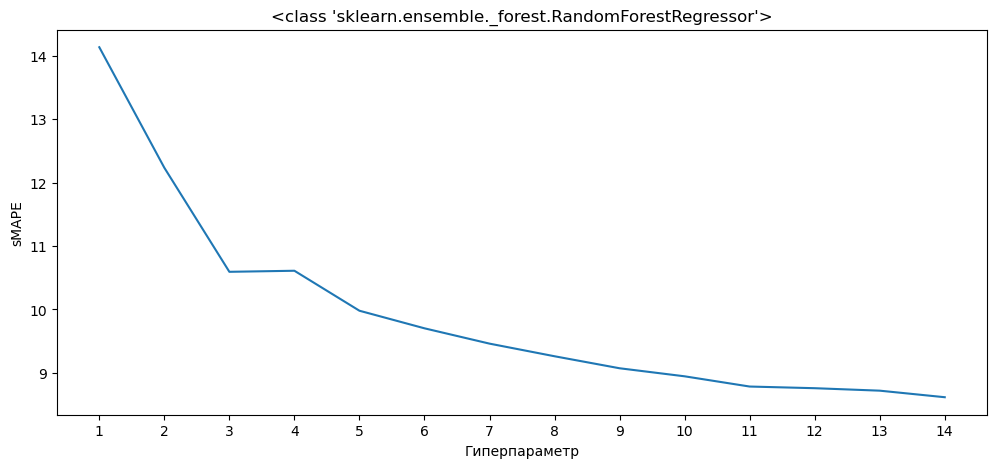

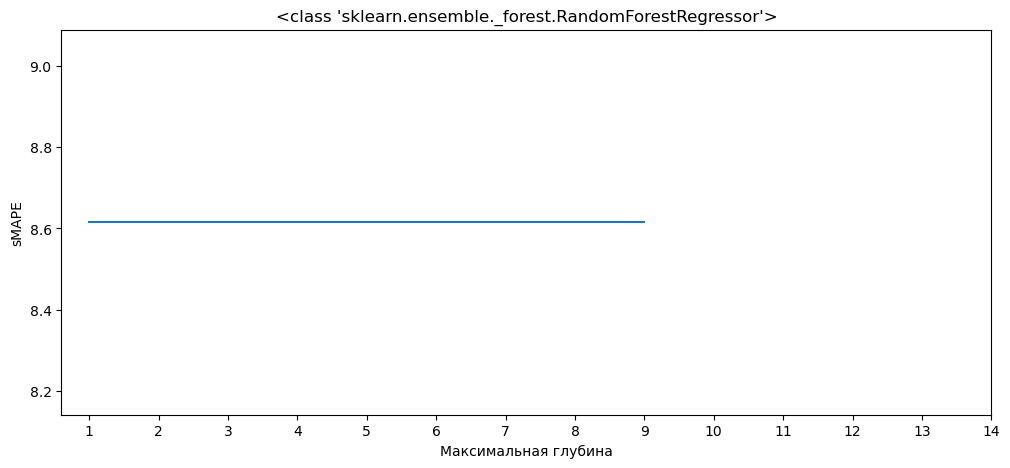

In [34]:
model_choice_graf(RandomForestRegressor, 1, 15, 1)

Видно, что для модели Случайного леса лучшей является RandomForestRegressor(max_depth=9, n_estimators=14, random_state=12345) с итоговым sMAPE, равным 8.62.

In [35]:
model_choice_graf(LinearRegression, 1, 2, 1)

Лучшая модель: LinearRegression()
Лучший sMAPE: 8.783
Время нахождения решения: 0.186
Лучший гиперпараметр: 1
Лучшая глубина для RF: None


(LinearRegression(), 8.783250786528892, 0.1856094999999982, 1, None)

Для модели Линейной регрессии итоговый sMAPE получился равным 8.783.

Лучшая модель: <catboost.core.CatBoostRegressor object at 0x000001F50052C7C0>
Лучший sMAPE: 7.655
Время нахождения решения: 234.702
Лучший гиперпараметр: 7
Лучшая глубина для RF: None


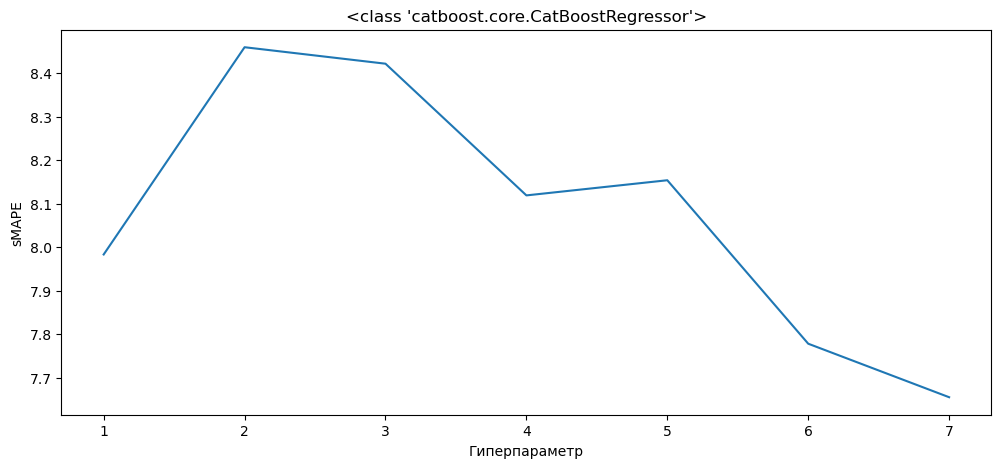

In [36]:
model_choice_graf(CatBoostRegressor, 1, 8, 1);

Видно, что для модели CatBoostRegressor лучшей является CatBoostRegressor(depth=7) с итоговым sMAPE, равным 7.655.

In [37]:
model_choice_graf(Ridge, 1, 2, 1)

Лучшая модель: Ridge()
Лучший sMAPE: 8.783
Время нахождения решения: 0.138
Лучший гиперпараметр: 1
Лучшая глубина для RF: None


(Ridge(), 8.782885851167842, 0.1381335000000945, 1, None)

Для модели Ridge итоговый sMAPE получился равным 8.783.

In [38]:
model_choice_graf(Lasso, 1, 2, 1)

Лучшая модель: Lasso()
Лучший sMAPE: 9.276
Время нахождения решения: 0.704
Лучший гиперпараметр: 1
Лучшая глубина для RF: None


(Lasso(), 9.275820265073992, 0.7044945999999754, 1, None)

Для модели Lasso итоговый sMAPE получился равным 9.276.

In [39]:
model_choice_graf(ElasticNet, 1, 2, 1)

Лучшая модель: ElasticNet()
Лучший sMAPE: 9.156
Время нахождения решения: 0.775
Лучший гиперпараметр: 1
Лучшая глубина для RF: None


(ElasticNet(), 9.155578264421077, 0.7753826000000572, 1, None)

Для модели ElasticNet итоговый sMAPE получился равным 9.156.

Лучшей моделью оказалась CatBoostRegressor(depth=7) с итоговым sMAPE, равным 7.655.

Модель выбрана, теперь проверим ее работу на тестовой выборке

In [40]:
#Напишем функцию для нахождения итогового sMAPE
def smape(target_rougher, predict_rougher, target_final, predict_final):
    smape_rougher = ((abs(target_rougher - predict_rougher) / 
                     ((target_rougher + predict_rougher) / 2)).sum() / 
                    target_rougher.count() * 100
                   )
    smape_final = ((abs(target_final - predict_final) / 
                    ((target_final + predict_final) / 2)).sum() / 
                   target_final.count() * 100
                  )
    final_smape = 0.25 * smape_rougher + 0.75 * smape_final 
    return final_smape

In [41]:
#Сначала нужно добавить целевой признак для тестовой выборки
data_full_1 = data_full[['date', 'rougher.output.recovery', 'final.output.recovery']]
data_test_3 = pd.merge(data_test_2, data_full_1).reset_index(drop=True)

#Теперь проверяем модель
target_test_rougher = data_test_3['rougher.output.recovery'].reset_index(drop=True)
features_test_rougher = data_test_rougher.reset_index(drop=True)
target_test_final = data_test_3['final.output.recovery'].reset_index(drop=True)
features_test_final = data_test_final.reset_index(drop=True)

model = CatBoostRegressor(depth=7, random_state=12345)
model.fit(features_rougher, target_rougher)
predict_rougher = model.predict(features_test_rougher)
predict_rougher = pd.Series(predict_rougher)

model.fit(features_final, target_final)
predict_final = model.predict(features_test_final)
predict_final = pd.Series(predict_final)

final_smape_test = smape(target_test_rougher, predict_rougher, target_test_final, predict_final)
print('Итоговый sMAPE на тестовой выборке составляет:', final_smape_test.round(3))

Learning rate set to 0.060801
0:	learn: 7.3355152	total: 9.65ms	remaining: 9.64s
1:	learn: 7.1161723	total: 16.7ms	remaining: 8.34s
2:	learn: 6.9203033	total: 23.3ms	remaining: 7.74s
3:	learn: 6.7422744	total: 30.1ms	remaining: 7.5s
4:	learn: 6.5641212	total: 36.5ms	remaining: 7.27s
5:	learn: 6.4101985	total: 43.1ms	remaining: 7.15s
6:	learn: 6.2706840	total: 49.2ms	remaining: 6.98s
7:	learn: 6.1299239	total: 55.8ms	remaining: 6.92s
8:	learn: 6.0044159	total: 62.3ms	remaining: 6.86s
9:	learn: 5.8919488	total: 67.9ms	remaining: 6.73s
10:	learn: 5.7872632	total: 73.7ms	remaining: 6.63s
11:	learn: 5.6923240	total: 79.8ms	remaining: 6.57s
12:	learn: 5.5998317	total: 86.6ms	remaining: 6.58s
13:	learn: 5.5204189	total: 93.4ms	remaining: 6.57s
14:	learn: 5.4354117	total: 99.8ms	remaining: 6.55s
15:	learn: 5.3498834	total: 106ms	remaining: 6.55s
16:	learn: 5.2821258	total: 112ms	remaining: 6.5s
17:	learn: 5.2125746	total: 118ms	remaining: 6.43s
18:	learn: 5.1495128	total: 124ms	remaining: 6.41

In [42]:
#Сравним результаты тестовой модели с константной
dummy_clf = DummyRegressor()
dummy_clf.fit(features_rougher, target_rougher)
predict_rougher_dummy = dummy_clf.predict(features_test_rougher)
predict_rougher_dummy = pd.Series(predict_rougher_dummy)

dummy_clf.fit(features_final, target_final)
predict_final_dummy = dummy_clf.predict(features_test_final)
predict_final_dummy = pd.Series(predict_final_dummy)

final_smape_dummy = smape(target_test_rougher, predict_rougher_dummy, target_test_final, predict_final_dummy)
print('Итоговый sMAPE константной модели составляет:', final_smape_dummy.round(3))

Итоговый sMAPE константной модели составляет: 7.531


**Выводы:**
1) Написана функция для вычисления итогового sMAPE; \
2) Обучено несколько моделей. Наилучшей оказалась CatBoostRegressor(depth=7, RandomState=12345); \
3) Итоговый sMAPE на тестовой выборке составил 6.908, это значение меньше, чем sMAPE на констатной модели (7.531).  

## Общие выводы

**1. Подготовка данных**:
1) Данные переведены в необходимые форматы; \
2) Удалены дубликаты и пропущенные значения; \
3) Данные по эффективности процессов представлены кооректно согласно сравнению с расчетом по формуле; \
4) В тестовой выборке отсутствуют значения результата процессов и некоторых вычислений, т.е. представлены признаки features, по которым необходимо делать прогноз; \
5) Данные разделены на два вида, соответствующие процессам флотации и очистки по отдельности. 
------

**2. Анализ данных**:

1) Можно сделать некоторые выводы по графикам изменения концентрации элементов для каждого процесса:
* Концентрация золота (Аu) - с каждым новым этапом очистки концентрация золота растет, что логично;
* Концентрация свинца (Pb) - в целом можно сделать вывод, что концентарция свинца увеличивается после первой очистки и остается примерно такой же после второй очистки
* Концентрация соли(?) (Sol) - концентарция соли(?) значительно снижается после первой очистки и остается примерно такой же после второй очистки
* Концентрация серебра (Ag) - концентарция серебра поэтапно снижается от этапа к этапу;

2) Как показывает гистограмма плотности распределения параметра, распределение величины зерен в обучающей и тестовых выборках примерно схожи;

3) По графикам и описанию суммарной концентрации для каждого процесса видно, что в сырье концентрация металлов ниже, чем в черновом и финальном концентратах. Это логично, ведь как раз процесс флотации необходим, чтобы убрать лишние элементы и вещества и оставить полезные. Также можно отметить, что между черновым и финальным концентратом в плане суммарной концентрации нет большой разницы, но по стандартному отклонению можно заметить, что суммарная концентарция более постояна после очистки. Это говорит о том, что во время очистки уже добиваются достижения увеличения концентрации золота с дополнительным удалением бесполезных элементов и некоторых других элементов (Sol и Ag);

4) Удалены значения, где суммарная концентрация элементов равно 0.

------

**3. Модель**:

1) Написана функция для вычисления итогового sMAPE; \
2) Обучено несколько моделей. Наилучшей оказалась CatBoostRegressor(depth=7, random_state=12345); \
3) Итоговый sMAPE на тестовой выборке составил 6.908, это значение меньше, чем sMAPE на констатной модели (7.531).